In [69]:
import torch
import torchvision
import torchvision.transforms as transforms

In [70]:
import string
classes = tuple(x for x in "_" + string.ascii_uppercase)

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

trainset = torchvision.datasets.EMNIST(root='./data', train=True,
                                        download=True, transform=transform, split="letters")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.EMNIST(root='./data', train=False,
                                       download=True, transform=transform, split="letters")
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


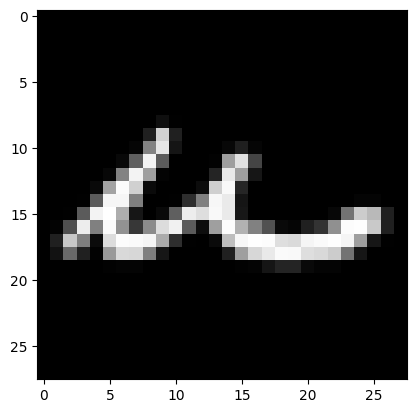

U    , tensor([21, 22, 19, 25])


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.rot90(npimg,3)
    npimg = np.fliplr(npimg)
    plt.imshow(npimg, cmap='gray')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images[0][0])
# print labels
print(f'{classes[labels[0]]:5s}, {labels}')

In [73]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)

tensor([18, 16,  2, 25])


In [74]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 27)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [75]:
import torchsummary 

torchsummary.summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 27]           2,295
Total params: 45,871
Trainable params: 45,871
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [76]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [77]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.272
[1,  4000] loss: 0.573
[1,  6000] loss: 0.478
[1,  8000] loss: 0.429
[1, 10000] loss: 0.411
[1, 12000] loss: 0.381
[1, 14000] loss: 0.357
[1, 16000] loss: 0.349
[1, 18000] loss: 0.348
[1, 20000] loss: 0.330
[1, 22000] loss: 0.325
[1, 24000] loss: 0.319
[1, 26000] loss: 0.309
[1, 28000] loss: 0.307
[1, 30000] loss: 0.308
[2,  2000] loss: 0.276
[2,  4000] loss: 0.282
[2,  6000] loss: 0.265
[2,  8000] loss: 0.286
[2, 10000] loss: 0.282
[2, 12000] loss: 0.291
[2, 14000] loss: 0.268
[2, 16000] loss: 0.284
[2, 18000] loss: 0.276
[2, 20000] loss: 0.265
[2, 22000] loss: 0.275
[2, 24000] loss: 0.274
[2, 26000] loss: 0.271
[2, 28000] loss: 0.257
[2, 30000] loss: 0.281
Finished Training


In [84]:
PATH = '../cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [85]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  A     A     A     A    


In [86]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [87]:
outputs = net(images)

In [88]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  A     A     A     Q    


In [89]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


In [90]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname]+ 0.00000000000001)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: _     is 0.0 %
Accuracy for class: A     is 89.8 %
Accuracy for class: B     is 96.0 %
Accuracy for class: C     is 97.2 %
Accuracy for class: D     is 93.1 %
Accuracy for class: E     is 91.8 %
Accuracy for class: F     is 94.8 %
Accuracy for class: G     is 73.0 %
Accuracy for class: H     is 90.8 %
Accuracy for class: I     is 46.2 %
Accuracy for class: J     is 90.4 %
Accuracy for class: K     is 94.6 %
Accuracy for class: L     is 86.2 %
Accuracy for class: M     is 98.8 %
Accuracy for class: N     is 91.1 %
Accuracy for class: O     is 96.9 %
Accuracy for class: P     is 97.0 %
Accuracy for class: Q     is 85.1 %
Accuracy for class: R     is 93.0 %
Accuracy for class: S     is 96.0 %
Accuracy for class: T     is 94.1 %
Accuracy for class: U     is 87.0 %
Accuracy for class: V     is 90.1 %
Accuracy for class: W     is 95.9 %
Accuracy for class: X     is 94.5 %
Accuracy for class: Y     is 96.2 %
Accuracy for class: Z     is 96.8 %


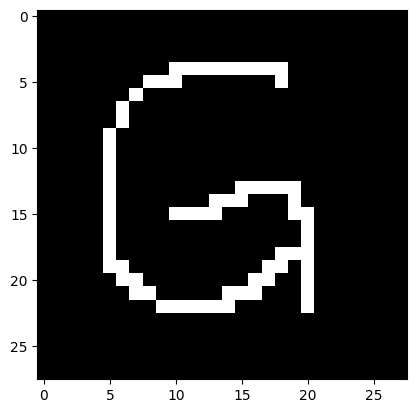

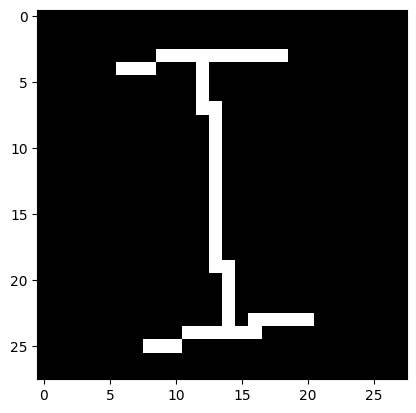

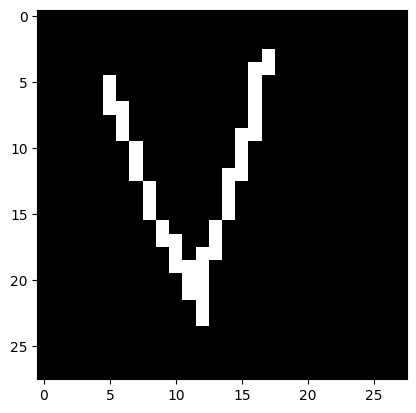

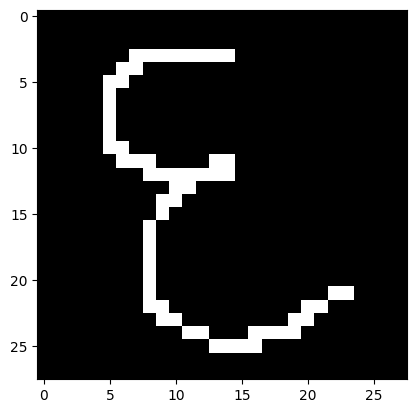

GIVE


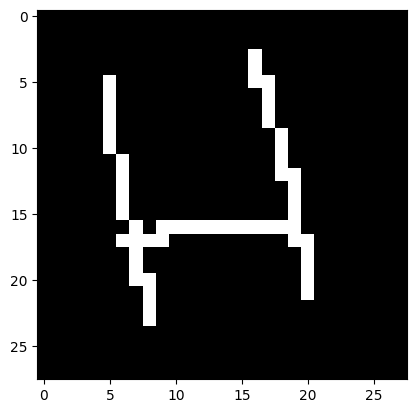

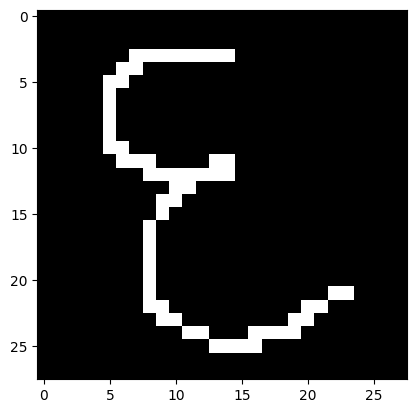

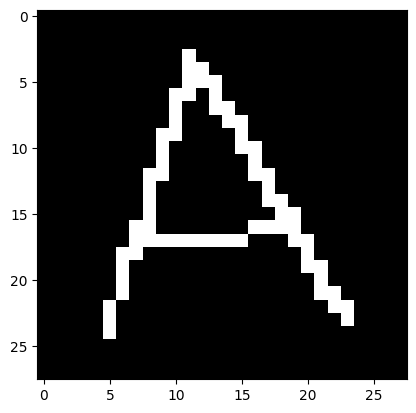

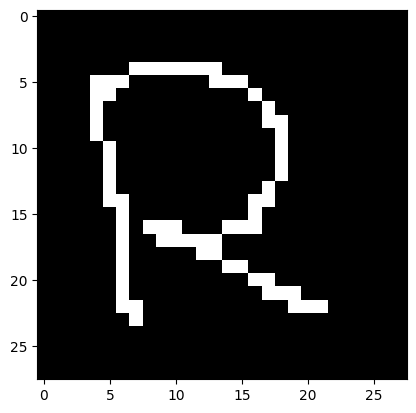

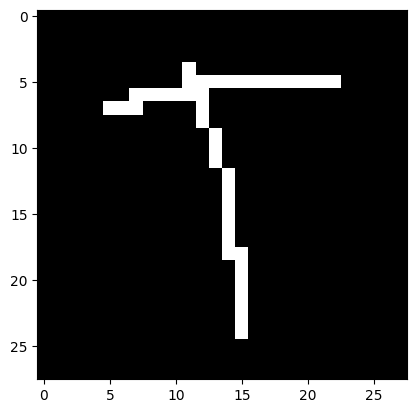

UEQEI


In [96]:
from PIL import Image
import torchvision.transforms.functional as TF

L = ['bigG', 'bigI','bigV','bigE']
M = ['bigH', 'bigE','bigA','bigR','bigT']


def read_from_image(L):
    word = ""
    for i in range(len(L)):
        image = Image.open("examples/demo/"+str(L[i])+".png")
        image = image.convert("1")
        x = TF.to_tensor(image).squeeze()
        x = x.numpy()
        #print(x.shape)
        x = np.fliplr(x)
        x = np.rot90(x)
        x = torch.from_numpy(x.copy())
        imshow(x)
        x = x.unsqueeze(0)
        #print(x.shape)
        output = net(x.unsqueeze(0))
        output = torch.softmax(output, 1)
        #print(output)
        output = torch.argmax(output)
        #print(f'{classes[output]:5s}') 
        word+=classes[output]
    return word
    
print(read_from_image(L))
print(read_from_image(M))